In [28]:
import os
import time

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

from ftx import FtxClient
from pycoingecko import CoinGeckoAPI

from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get futures and funding rates from FTX

In [2]:
def get_futures_data() -> pd.DataFrame:
    ftx = FtxClient()

    futures = ftx.get_futures()
    funding_rates = ftx.get_funding_rates()

    df = pd.DataFrame(columns=["market", "name", "open_interest", "funding_rate"])

    idx = 0
    for future in futures:
        if future["perpetual"]:
            for funding in funding_rates:
                if funding["future"] == future["name"]:
                    funding_rate = funding["rate"]
                    break
            df.loc[idx] = [future["name"], future["underlying"], future["openInterestUsd"], funding_rate]
            idx += 1
    
    return df

# Get market caps from CoinGecko

In [3]:
def get_market_cap_data(df: pd.DataFrame) -> pd.DataFrame:
    cg = CoinGeckoAPI()
    markets = cg.get_coins_markets(vs_currency=["usd"], per_page=250)
    
    market_caps = np.zeros(len(df))
    future_dilutions = np.zeros(len(df))

    for idx, name in enumerate(df["name"]):
        market_cap = 0
        future_dilution = 1
        for market in markets:
            if name.lower() == market["symbol"].lower():
                market_cap = market["market_cap"]
                if market["fully_diluted_valuation"]:
                    future_dilution = market["fully_diluted_valuation"] / market["market_cap"]
                elif market["max_supply"]:
                    future_dilution = market["max_supply"] / market["circulating_supply"]
                elif market["total_supply"]:
                    future_dilution = market["total_supply"] / market["circulating_supply"]
                break
        market_caps[idx] = market_cap
        future_dilutions[idx] = future_dilution

    df["market_cap"] = market_caps
    df["future_dilution"] = future_dilutions


    # Remove any values without market caps
    df = df[df["market_cap"] != 0]
    df = df.reset_index(drop=True)
    
    return df

# Calculate the FOM metric

The calculation of the derived metric is simple, the idea is to take the open interest in the market $i$ and normalize it with the market cap. This ratio can be then multiplied with the absolute value of the funding rate. A large value would indicate a strong perp bias towards one direction. The direction is indicated by the sign of the funding rate. 

Let, 
$$ FR_i = \text{funding rate of market i} $$
$$ OI_i = \text{open interest of market i in USD} $$
$$ MC_i = \text{market cap of market i in USD} $$
$$ D_i = \text{future dilution of market i} = \frac{FDV}{MCAP} \text{or} \frac{N_{max}}{N_{circ}}  \text{or} \frac{N_{total}}{N_{circ}} $$

The derived FOM metric, 

$$ FOM_i = \left(\frac{OI_i}{MC_i}\right) \times abs(FR_i) \times D_i $$

In [20]:
df = get_futures_data()
df = get_market_cap_data(df)
df["oi_macp_ratio"] = df["open_interest"] / df["market_cap"]

scaler = MinMaxScaler()
df['oi_macp_ratio_scaled'] = scaler.fit_transform(df['oi_macp_ratio'].values.reshape(-1, 1))
df['future_dilution_scaled'] = scaler.fit_transform(df['future_dilution'].values.reshape(-1, 1))

df["fom"] = df["oi_macp_ratio_scaled"] * df["future_dilution_scaled"] * df["funding_rate"].abs()
df = df.sort_values("fom", ascending=False)

# Plotting the FOM

We see a strong variation in FOM across different cryptos. We can filter this by looking at the top 5 percentile.

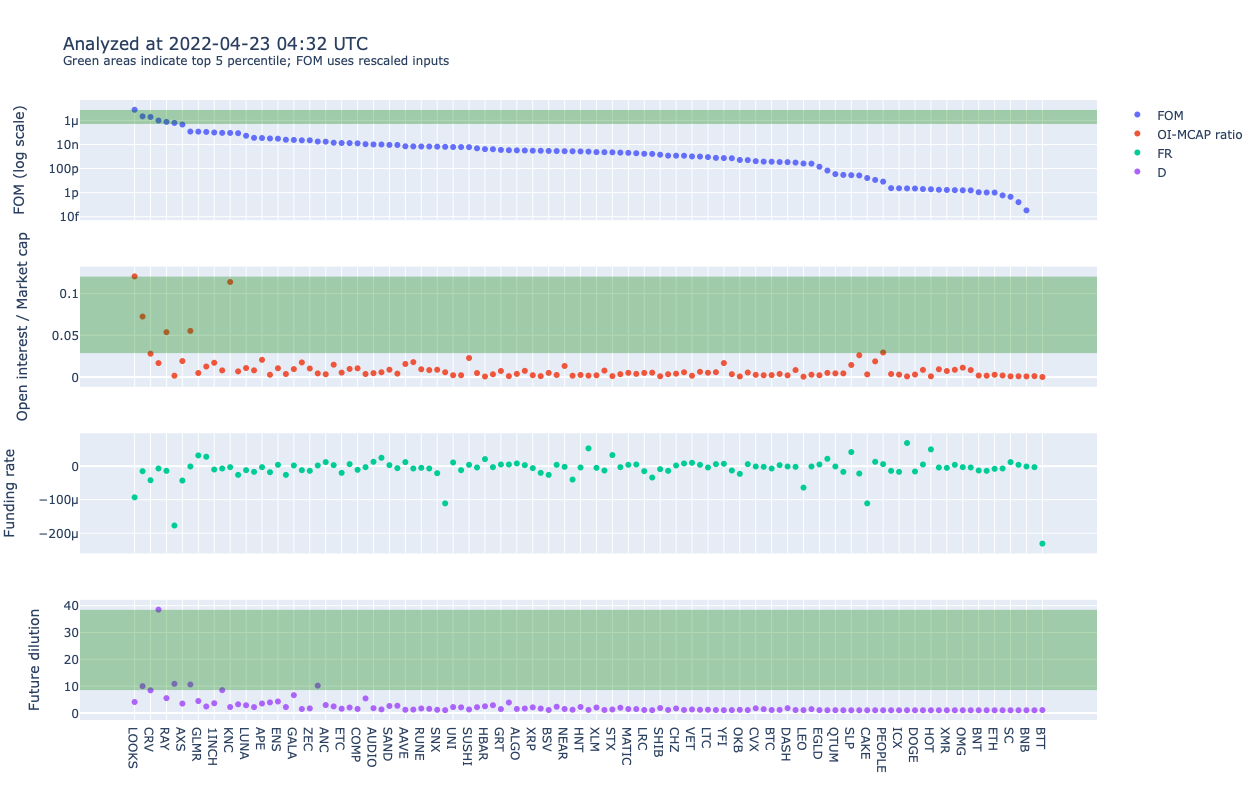

In [29]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True)

fig.add_trace(
    go.Scatter(
        x=df["name"],
        y=df["fom"],
        mode="markers",
        name="FOM"
    ),
    row=1,
    col=1
)

top_5_percentile_fom = np.percentile(df["fom"], 95)
fig.add_hrect(
    y0=top_5_percentile_fom,
    y1=df["fom"].max(),
    fillcolor="green",
    opacity=0.3,
    line_width=0,
    row=1,
    col=1
)

fig.add_trace(
    go.Scatter(
        x=df["name"],
        y=df["oi_macp_ratio"],
        mode="markers",
        name="OI-MCAP ratio"
    ),
    row=2,
    col=1
)
top_5_percentile_oi_mcap = np.percentile(df["oi_macp_ratio"], 95)
fig.add_hrect(
    y0=top_5_percentile_oi_mcap,
    y1=df["oi_macp_ratio"].max(),
    fillcolor="green",
    opacity=0.3,
    line_width=0,
    row=2,
    col=1
)

fig.add_trace(
    go.Scatter(
        x=df["name"],
        y=df["funding_rate"],
        mode="markers",
        name="FR"
    ),
    row=3,
    col=1
)

fig.add_trace(
    go.Scatter(
        x=df["name"],
        y=df["future_dilution"],
        mode="markers",
        name="D"
    ),
    row=4,
    col=1
)
top_5_percentile_fd = np.percentile(df["future_dilution"], 95)
fig.add_hrect(
    y0=top_5_percentile_fd,
    y1=df["future_dilution"].max(),
    fillcolor="green",
    opacity=0.3,
    line_width=0,
    row=4,
    col=1
)


fig['layout']['yaxis']['type'] = 'log'
fig['layout']['yaxis']['title'] = 'FOM (log scale)'

fig['layout']['yaxis2']['title'] = 'Open interest / Market cap'
fig['layout']['yaxis3']['title'] = 'Funding rate'
fig['layout']['yaxis4']['title'] = 'Future dilution'

fig.update_layout(
    title=f"Analyzed at {datetime.now().strftime('%Y-%m-%d %H:%M')} UTC" + "<br><sup>Green areas indicate top 5 percentile; FOM uses rescaled inputs</sup>",
    height=800, width=1000
)


fig.write_image(os.path.join("..", "images", "fom_metric.png"))
fig.show()

In [30]:
df[df["fom"] > top_5_percentile_fom]

,market,name,open_interest,funding_rate,market_cap,future_dilution,oi_macp_ratio,oi_macp_ratio_scaled,future_dilution_scaled,fom
62,LOOKS-PERP,LOOKS,5.101088e+07,-0.000093,4.237209e+08,4.072163,0.120388,1.000000,0.081858,7.612821e-06
47,GMT-PERP,GMT,1.361474e+08,-0.000015,1.881623e+09,10.000000,0.072356,0.600763,0.239796,2.160906e-06
26,CRV-PERP,CRV,2.733753e+07,-0.000042,9.791859e+08,8.426998,0.027919,0.231399,0.197886,1.923200e-06
94,SRM-PERP,SRM,1.056495e+07,-0.000007,6.316139e+08,38.532620,0.016727,0.138373,1.000000,9.686143e-07
80,RAY-PERP,RAY,1.403416e+07,-0.000014,2.614500e+08,5.511929,0.053678,0.445511,0.120218,7.498209e-07
13,BIT-PERP,BIT,1.912507e+06,-0.000177,1.150622e+09,10.866649,0.001662,0.013156,0.262886,6.121487e-07


**Q.** Why are the FOM values high for certain projects?   
**A.** Some possible reasons:
1. Upcoming token unlocks causing sell pressure (use `future_dilution` as a reference)
2. Sell pressure from spot holders compounding profits using perps
3. Project holders hedging spot positions

**Q.** Should I use this as an entry signal?  
**A.** Alone, this isn't really enough. It can point you to the right projects to short/long, but entry/exit levels will have to be done separately (not financial advice ofc).

# Plot the variation of FOM with time

In [ ]:
fig = make_subplots()

while True:
    clear_output(wait=True)
    
    df = get_futures_data()
    df = get_market_cap_data(df)
    df["oi_macsp_ratio"] = df["open_interest"] / df["market_cap"]
    df["fom"] = df["oi_macp_ratio"] *  df["funding_rate"].abs()
    df = df.sort_values("fom", ascending=False).head()
    
    display(df)
    
    fig.append_trace(
        go.Scatter(
            x=df["market"],
            y=df["fom"],
            mode="markers",
            name=f"{datetime.now()}"
        ),
        row=1,
        col=1,
    )

    fig.show()
    
    time.sleep(60 * 30)